In [150]:
from src.ETL import *
import skimage 
import sklearn
from sklearn import svm
from skimage import io
from skimage.color import rgb2hsv
from scipy import ndimage
from sklearn.model_selection import train_test_split
from skimage import exposure
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2gray
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
RESULTS_DIR='../results'

### Small background
To start, the appropriate file has to be downloaded from kaggle. The kaggle dataset can be found [here](https://www.kaggle.com/neha1703/movie-genre-from-its-poster). Downloading directly will result in a zip file that needs to be extracted and get the csv.

### BASIC EDA STATS
These stats were extracted based on code [from this medium article](https://towardsdatascience.com/movie-posters-81af5707e69a) and can be found on this linked [github](https://github.com/timo-boehm/material_blog_posts/blob/master/collect_movie_posters.ipynb). The small snippet below reads in the dataset and shows a dataframe for action movies and romance movies.

In [3]:
movie_data = read_and_clean_data(path="data/MovieGenre.csv")
movie_data = add_year_variable(movie_data)
movie_data = create_boolean_genres(movie_data)
action_movies = extract_genre_data(movie_data, "Action")
action_movies = select_years(action_movies, 1970, 2018)
action_sample = sample_same_number_per_decade(action_movies, use_test_sample=False)

Shape of the original dataset: (40108, 3)
Shape after dropping rows with missing values: (39263, 3)
Shape after dropping rows with potentially misleading poster link: (37850, 3)

There are movies between 1874 and 2018 available in the dataset.

There are 28 genres in the dataset: {'Game-Show', 'Musical', 'News', 'Drama', 'Fantasy', 'Biography', 'Action', 'Sci-Fi', 'Film-Noir', 'Horror', 'Romance', 'Western', 'War', 'Short', 'Crime', 'Thriller', 'Family', 'Talk-Show', 'Documentary', 'Adult', 'Sport', 'Music', 'Reality-TV', 'Animation', 'Comedy', 'Adventure', 'Mystery', 'History'}

Action movies in the dataset: 5133

Movies left between 1970 and 2018: 4614
Movies per decade in the dataset:
10s    1381
00s    1327
90s     855
80s     582
70s     469
Name: decade, dtype: int64

Sample includes 469 movies per decade


In [4]:
romance_movies = extract_genre_data(movie_data, "Romance")
romance_movies = select_years(romance_movies, 1970, 2018)
romance_sample = sample_same_number_per_decade(romance_movies, use_test_sample=False)

Romance movies in the dataset: 5932

Movies left between 1970 and 2018: 4381
Movies per decade in the dataset:
00s    1562
10s    1184
90s     935
80s     440
70s     260
Name: decade, dtype: int64

Sample includes 260 movies per decade


### Downloading the images

Code from the medium article splits up the dataset into training and test sets. This snippet below a train and test directory and then makes multiple directories in each based on decade and downloads the images. Again this is only for the sample on action movies.

This snippet below will download the entire dataset without seperating into training and test sets.

In [5]:
image_folder = "action_posters"
create_all_folders(image_folder=image_folder, classes = set(action_sample.decade))
download_all(action_sample, image_folder=image_folder)

action_posters/all/70s already exists.
action_posters/all/80s already exists.
action_posters/all/90s already exists.
action_posters/all/00s already exists.
action_posters/all/10s already exists.


Starting with all downloading files..

151 posters had an HTTPError.
1706 posters were downloaded before.

Number of pictures in action_posters/all/70s:	434
Number of pictures in action_posters/all/80s:	521
Number of pictures in action_posters/all/90s:	721
Number of pictures in action_posters/all/10s:	958
Number of pictures in action_posters/all/00s:	925

Total number of pictures available for all: 3559



In [6]:
image_folder = "romance_posters"
create_all_folders(image_folder=image_folder, classes = set(romance_sample.decade))
download_all(romance_sample, image_folder=image_folder)

romance_posters/all/70s already exists.
romance_posters/all/80s already exists.
romance_posters/all/90s already exists.
romance_posters/all/00s already exists.
romance_posters/all/10s already exists.


Starting with all downloading files..

67 posters had an HTTPError.
752 posters were downloaded before.

Number of pictures in romance_posters/all/70s:	239
Number of pictures in romance_posters/all/10s:	603
Number of pictures in romance_posters/all/00s:	642
Number of pictures in romance_posters/all/80s:	370
Number of pictures in romance_posters/all/90s:	545

Total number of pictures available for all: 2399



### Movie Genre Statistics

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
sns.set(color_codes=True)

#### Distribution of Movies Over Each Decade

In [8]:
# get counts per year
years = pd.DataFrame(movie_data.groupby('year').size()).reset_index()
years.columns=['year', 'count']
years=years.loc[years.year>=1970]

# relabel by decade
years['decade']=years.year.apply(lambda x: (x//10)*10)

# get counts of decade
decades = pd.DataFrame(years.groupby('decade')['count'].sum()).reset_index()

# read decade as integer
decades.decade = decades.decade.apply(lambda x: int(x))
decades.columns=['decade', 'count']

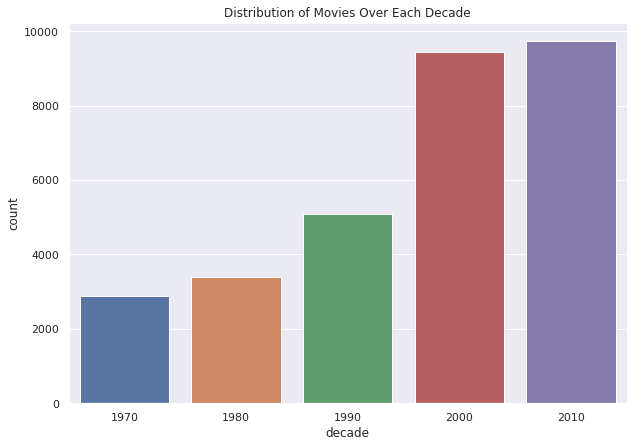

In [9]:
#plot
plt.figure(figsize=(10,7))
fig1 = (
    sns.barplot(x='decade', y='count', data=decades)
    .set_title('Distribution of Movies Over Each Decade')
)
plt.savefig('results/dist_of_movies_over_each_decade.jpg');

#### Distribution of Movie Genres

In [10]:
# df with the one-hot genres
genres_ohe=movie_data.drop(columns=['Title', 'Poster', 'year'])

In [11]:
genres = genres_ohe.sum()
genres = genres.sort_values(ascending=False)[:10]

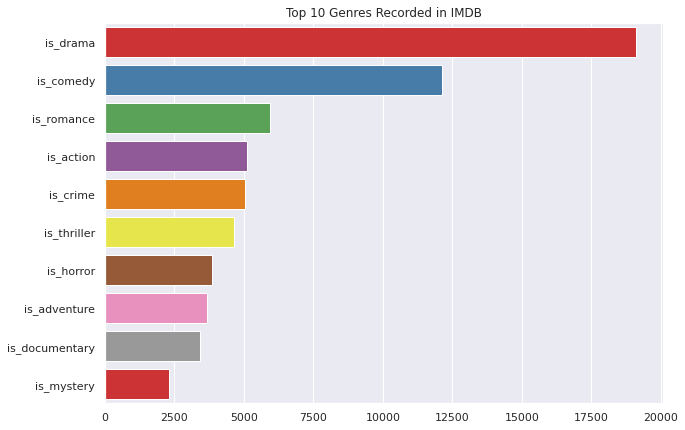

In [12]:
plt.figure(figsize=(10,7))
fig2 = sns.barplot(genres.values, genres.index, palette='Set1')
fig2.set_title('Top 10 Genres Recorded in IMDB');
plt.savefig('results/top_ten_genres.jpg');

In [13]:
movie_data['decade']=movie_data.year.apply(lambda x: (x//10)*10)

In [14]:
genre_dec=movie_data.groupby('decade').sum().reset_index().drop(columns=['year'])
genre_dec=genre_dec.loc[genre_dec.decade>=1970]
genre_dec=genre_dec.groupby('decade').sum()[['is_action', 'is_romance']]
genre_dec.index = pd.Series(genre_dec.index).apply(lambda x: str(int(x)))
genre_dec = genre_dec.reset_index()

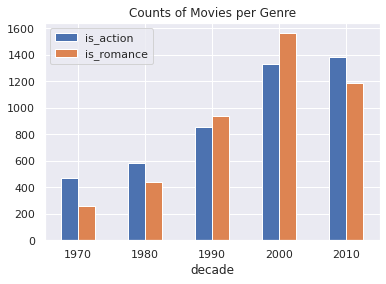

In [15]:
genre_dec.set_index('decade').plot(kind='bar').set_title('Counts of Movies per Genre')
plt.xticks(rotation=0)
plt.savefig('results/counts_of_movies_per_genre.jpg');

### Extracting Movie Poster Image Features

In [16]:
import os
from IPython.display import Image, display
import glob

In [17]:
# import the necessary packages
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2

#### Colorfulness

In [18]:
def image_colorfulness(image):
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(image.astype("float"))
    # compute rg = R - G
    rg = np.absolute(R - G)
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

#### Corners

In [19]:
FOLD_DIR = 'action_posters/all'
decades = ['00s', '10s', '70s', '80s', '90s']

In [20]:
def image_dir_decade(decade):
    return f'{FOLD_DIR}/{decade}'

In [21]:
image_dir_decade('00s')

'action_posters/all/00s'

In [22]:
if not os.path.exists(image_dir_decade('00s')):
    print('fail')

In [23]:
action_list=[]
count=0
for decade in decades:
    decade_path = image_dir_decade(decade)
    for imagePath in glob.glob('{}/*.jpg'.format(decade_path)): #assuming JPG
        filename=imagePath.split('/')[-1]
        filepath = decade_path + '/' + filename
        action_list.append(filepath)
    #     df_list.append(calc_stats(filename))
        count+=1
    #     print("Uploaded {}".format(count) + filename)

In [24]:
action_list[0]

'action_posters/all/00s/891562.jpg'

In [25]:
corners_list = []
colorfulness_list = []
for i in range(len(action_list)):
    image_path = action_list[i]
    img = cv2.imread(image_path)
    # calculating colorfulness
    colorfulness = image_colorfulness(img)
    colorfulness_list.append(colorfulness)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Harris corners
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    corners_list.append(len(corners))

In [26]:
action_feat=pd.DataFrame({'img':action_list, 'num_corners': corners_list, 'colorfulness': colorfulness_list})
action_feat['imdbId']=action_feat.img.apply(lambda x: int(x.split('/')[-1].split('.')[0]))
action_feat=action_feat.merge(action_sample, on='imdbId')

In [27]:
action_feat.to_csv('data/action_feat.csv', index=False)

In [28]:
action_feat = pd.read_csv('data/action_feat.csv')

In [29]:
action_feat.groupby('decade')['num_corners'].mean()

decade
00s    110.721088
10s    111.685466
70s    112.117512
80s    109.116945
90s    103.744875
Name: num_corners, dtype: float64

In [30]:
action_feat.groupby('decade')['colorfulness'].mean()

decade
00s    55.240650
10s    49.454936
70s    60.299711
80s    58.459238
90s    62.970935
Name: colorfulness, dtype: float64

#### Romance

In [31]:
FOLD_DIR = 'romance_posters/all'
decades = ['00s', '10s', '70s', '80s', '90s']

In [32]:
def image_dir_decade(decade):
    return f'{FOLD_DIR}/{decade}'

In [33]:
image_dir_decade('00s')

'romance_posters/all/00s'

In [34]:
romance_list=[]
count=0
for decade in decades:
    decade_path = image_dir_decade(decade)
    for imagePath in glob.glob('{}/*.jpg'.format(decade_path)): #assuming JPG
        filename=imagePath.split('/')[-1]
        filepath = decade_path + '/' + filename
        romance_list.append(filepath)
        count+=1


In [35]:
romance_list[0]

'romance_posters/all/00s/211915.jpg'

In [36]:
corners_list = []
colorfulness_list = []
for i in range(len(romance_list)):
    image_path = romance_list[i]
    img = cv2.imread(image_path)
    # calculating colorfulness
    colorfulness = image_colorfulness(img)
    colorfulness_list.append(colorfulness)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Harris corners
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    corners_list.append(len(corners))

In [37]:
romance_feat=pd.DataFrame({'img':romance_list, 'num_corners': corners_list, 'colorfulness': colorfulness_list})
romance_feat['imdbId']=romance_feat.img.apply(lambda x: int(x.split('/')[-1].split('.')[0]))
romance_feat=romance_feat.merge(romance_sample, on='imdbId')

In [38]:
romance_feat.to_csv('data/romance_feat.csv', index=False)

In [39]:
romance_feat = pd.read_csv('data/romance_feat.csv')

In [40]:
romance_feat.groupby('decade')['num_corners'].mean()

decade
00s    100.583333
10s    103.089494
70s     97.071130
80s     98.991667
90s     99.624490
Name: num_corners, dtype: float64

In [41]:
romance_feat.groupby('decade')['colorfulness'].mean()

decade
00s    55.113480
10s    54.234091
70s    52.247036
80s    52.362842
90s    55.956154
Name: colorfulness, dtype: float64

### Visualize Features

In [42]:
decade_order = ['70s', '80s', '90s', '00s', '10s']

In [43]:
grouped_corners = pd.DataFrame(action_feat.groupby('decade')['num_corners'].mean().loc[decade_order]).loc[decade_order]#.reset_index()
grouped_corners.columns = ['action_corners']
grouped_corners['romance_corners'] = romance_feat.groupby('decade')['num_corners'].mean().loc[decade_order].loc[decade_order].values

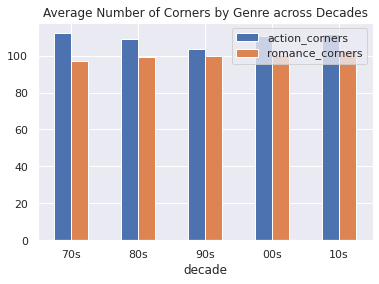

In [44]:
grouped_corners.plot(kind='bar')
plt.title('Average Number of Corners by Genre across Decades')
plt.xticks(rotation=0)
plt.savefig('results/corners.jpg');

In [45]:
grouped_color = pd.DataFrame(action_feat.groupby('decade')['colorfulness'].mean().loc[decade_order]).loc[decade_order]#.reset_index()
grouped_color.columns = ['action_colorfulness']
grouped_color['romance_colorfulness'] = romance_feat.groupby('decade')['colorfulness'].mean().loc[decade_order].loc[decade_order].values

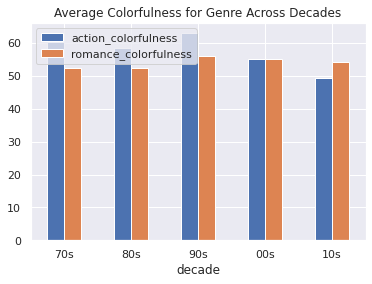

In [46]:
grouped_color.plot(kind='bar')
plt.title('Average Colorfulness for Genre Across Decades')
plt.xticks(rotation=0)
plt.savefig('results/colorfulness.jpg');

## Corner Demonstration

In [47]:
    image_path = action_list[0]
    img = io.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Harris corners
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

In [48]:
# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

In [49]:
img[dst>0.01*dst.max()]=[0,0,255]

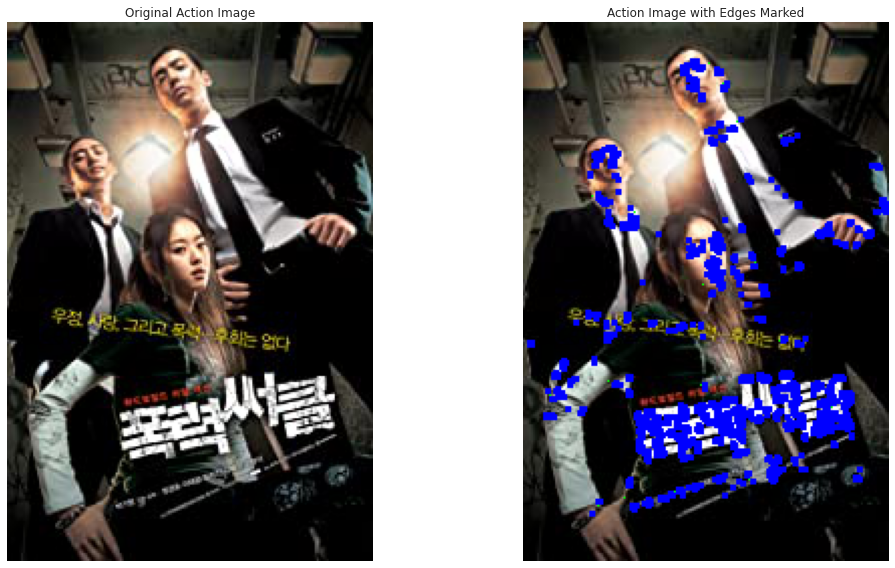

In [50]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(io.imread(image_path))
ax0.set_title("Original Action Image")
ax0.axis('off')
ax1.imshow(img)
ax1.set_title("Action Image with Edges Marked")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/action_corners.jpg');

In [51]:
len(corners)

92

In [52]:
    image_path = romance_list[-1]
    img = io.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Harris corners
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

In [53]:
# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

In [54]:
img[dst>0.01*dst.max()]=[0,0,255]

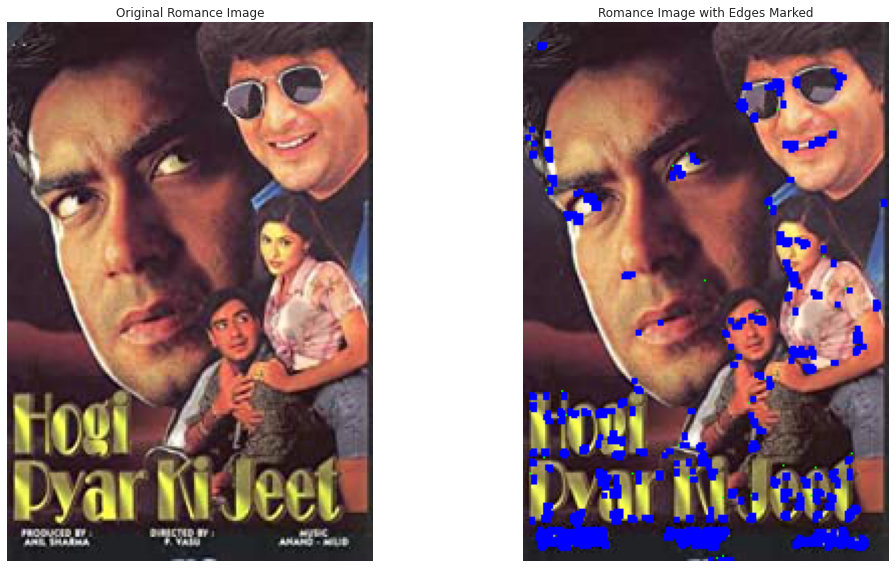

In [76]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(io.imread(image_path))
ax0.set_title("Original Romance Image")
ax0.axis('off')
ax1.imshow(img)
ax1.set_title("Romance Image with Edges Marked")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/romance_corners.jpg');

In [56]:
len(corners)

124

## Colorfulness Demonstration

In [57]:
def get_list(df):
    ret = []
    for index, row in df.iterrows():
        image_path = row[0]
        C = row[1]
        image = skimage.img_as_ubyte(io.imread(image_path))
        if len(image.shape) != 3:
            image = cv2.imread(image_path)
        cv2.putText(image, "{:.2f}".format(C), (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 255, 0), 3)
        ret.append((image, C))
    return ret

In [58]:
top_9_action = action_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[:9]
top_9_action_list = get_list(top_9_action)
mostColor_action = [r[0] for r in top_9_action_list[:25]]
mostColorMontage_action = build_montages(mostColor_action, (128, 128), (3, 3))

In [59]:
bottom_9_action = action_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[-9:]
bottom_9_action_list = get_list(bottom_9_action)
leastColor_action = [r[0] for r in bottom_9_action_list[:25]]
leastColorMontage_action = build_montages(leastColor_action, (128, 128), (3, 3))

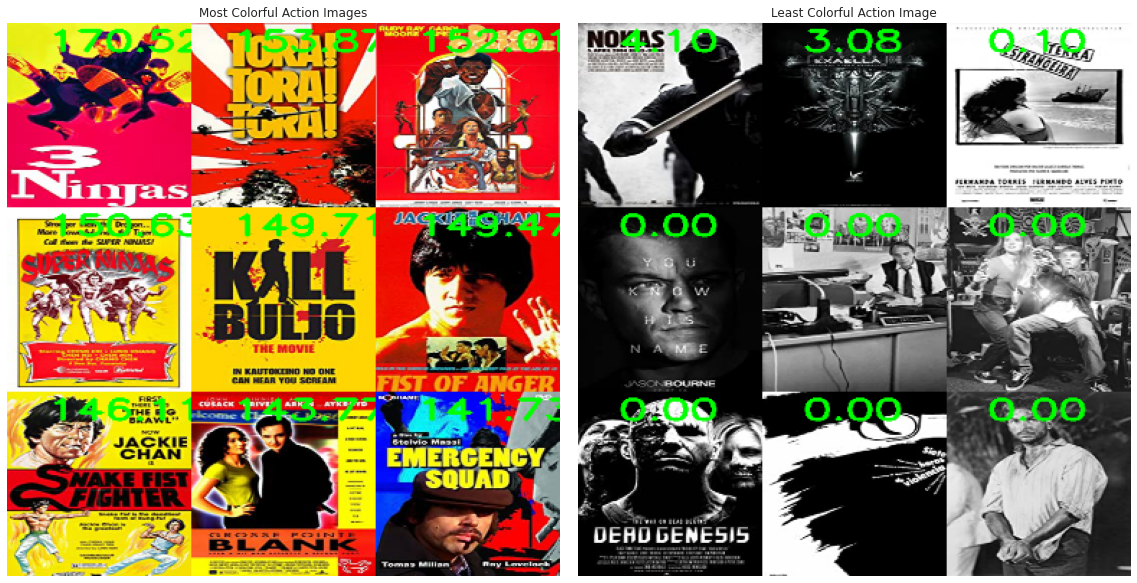

In [60]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(mostColorMontage_action[0])
ax0.set_title("Most Colorful Action Images")
ax0.axis('off')
ax1.imshow(leastColorMontage_action[0])
ax1.set_title("Least Colorful Action Image")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/action_colorfulness.jpg');

In [61]:
top_9_romance = romance_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[:9]
top_9_romance_list = get_list(top_9_romance)
mostColor_romance = [r[0] for r in top_9_romance_list[:25]]
mostColorMontage_romance = build_montages(mostColor_romance, (128, 128), (3, 3))

In [62]:
bottom_9_romance = romance_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[-9:]
bottom_9_romance_list = get_list(bottom_9_romance)
leastColor_romance = [r[0] for r in bottom_9_romance_list[:25]]
leastColorMontage_romance = build_montages(leastColor_romance, (128, 128), (3, 3))

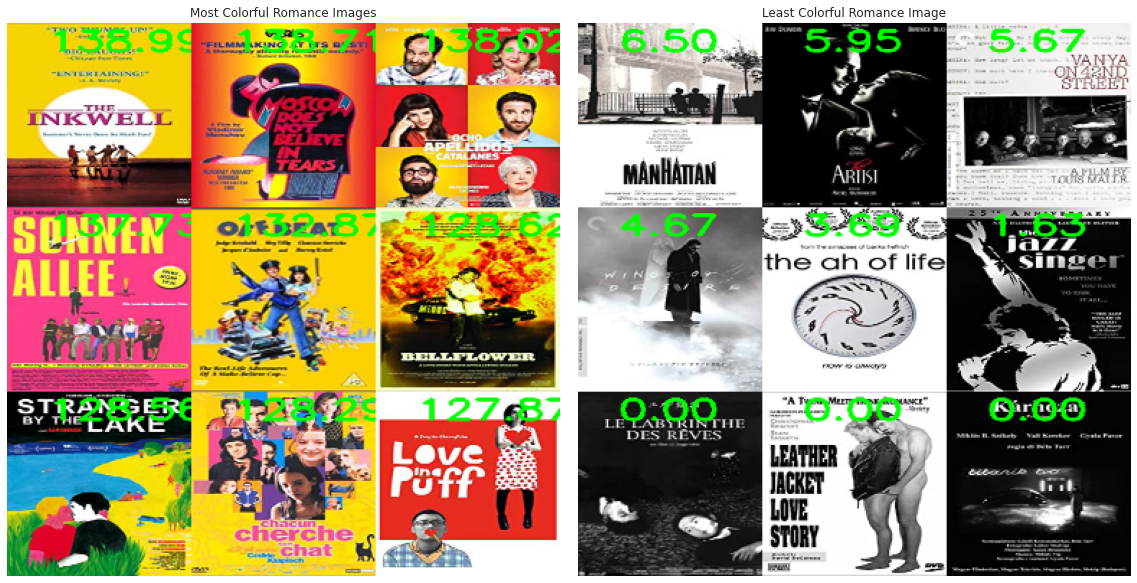

In [63]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(mostColorMontage_romance[0])
ax0.set_title("Most Colorful Romance Images")
ax0.axis('off')
ax1.imshow(leastColorMontage_romance[0])
ax1.set_title("Least Colorful Romance Image")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/romance_colorfulness.jpg');

In [141]:
def make_list(decades):
    lst=[]
    count=0
    for decade in decades:
        decade_path = image_dir_decade(decade)
        for imagePath in glob.glob('{}/*.jpg'.format(decade_path)): #assuming JPG
            filename=imagePath.split('/')[-1]
            filepath = decade_path + '/' + filename
            lst.append(filepath)
            count+=1
    return lst     

def calcDGenergy(img):
    # from from https://stackoverflow.com/a/48974892

    #convert from uint8 to int64 to prevent overflow problems
    arr = np.array(img, dtype = int)

    #calculate squared difference ((x-1, y) - (x+1, y))^2 for each R, G and B pixel
    deltaX2 = np.square(np.roll(arr, -1, axis = 0) - np.roll(arr, 1, axis = 0))

    #same for y axis
    deltaY2 = np.square(np.roll(arr, -1, axis = 1) - np.roll(arr, 1, axis = 1))

    #add R, G and B values for each pixel, then add x- and y-shifted values
    dualEnergy = np.sum(deltaX2, axis = 2) + np.sum(deltaY2, axis = 2)
    return dualEnergy


def make_features(lst):
    corners_list = []
    colorfulness_list = []
    energy_list = []
    hue_list = []
    sat_list = []
    val_list = []
    edge_list = []
    sum_edge_list = []
    width_list = []
    height_list = []
    #lines_list = []
    entropy_list = []
    for i in range(len(lst)):
        image_path = lst[i]
        image = skimage.img_as_ubyte(io.imread(image_path))
        if len(image.shape) != 3:
            image = cv2.imread(image_path)
        
        image_width = image.shape[1]
        image_height = image.shape[0]
        width_list.append(image_width)
        height_list.append(image_height)
        energy_mean = calcDGenergy(img).mean()
        energy_list.append(energy_mean)
        
        hsv_img = rgb2hsv(image)
        hue_img = hsv_img[:, :, 0]
        saturation_img = hsv_img[:,:, 1]
        value_img = hsv_img[:, :, 2]
        hue_list.append(np.mean(hue_img, axis=(0,1)))
        sat_list.append(np.mean(saturation_img, axis=(0,1)))
        val_list.append(np.mean(value_img))
        
        sobel_x = ndimage.sobel(value_img, axis=1, mode='constant')
        sobel_y = ndimage.sobel(value_img, axis=0, mode='constant')
        edge_image = np.hypot(sobel_x, sobel_y)
        edge_list.append(edge_image.mean())
        sum_of_edge_image = np.sum(edge_image)/ (edge_image.size)
        sum_edge_list.append(sum_of_edge_image)
        #temp = exposure.rescale_intensity(edge_image, out_range=(-1.0, 1.0))

        #edges = skimage.img_as_ubyte(np.clip(temp, -1, 1))
        #minLineLength = 400
        #maxLineGap = 10

        #lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
        #lines_list.append(len(lines))
        gray_img = rgb2gray(image)
        entr_img = entropy(gray_img, disk(10))
        entropy_list.append(entr_img.mean())

        colorfulness = image_colorfulness(img)
        colorfulness_list.append(colorfulness)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # find Harris corners
        gray = np.float32(gray)
        dst = cv2.cornerHarris(gray,2,3,0.04)
        dst = cv2.dilate(dst,None)
        ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
        dst = np.uint8(dst)
        # find centroids
        ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
        # define the criteria to stop and refine the corners
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
        corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
        corners_list.append(len(corners))
        
    return energy_list, hue_list, sat_list,val_list, edge_list, corners_list, colorfulness_list, width_list, height_list, sum_edge_list,entropy_list 

In [142]:
%%time
FOLD_DIR = 'action_posters/all'
action_list = make_list(decades)
energy_list, hue_list, sat_list,val_list, edge_list,corners_list, colorfulness_list, width_list, height_list, sum_edge_list,entropy_list  = make_features(action_list)
all_action_feat=pd.DataFrame({'img':action_list, 'num_corners': corners_list, 'colorfulness': colorfulness_list, 'mean_energy': energy_list, 'mean_hue':hue_list, 'mean_saturation':sat_list,'mean_bright':val_list, 
                              'edge_mean':edge_list, 'width':width_list, 'height':height_list, 'sum_edges':sum_edge_list,'entropy':entropy_list})
all_action_feat['imdbId']=all_action_feat.img.apply(lambda x: int(x.split('/')[-1].split('.')[0]))
all_action_feat=all_action_feat.merge(action_sample, on='imdbId')

CPU times: user 12min 54s, sys: 5.64 s, total: 12min 59s
Wall time: 12min 6s


In [189]:
X_train, X_test, y_train, y_test = train_test_split(all_action_feat[['num_corners', 'colorfulness', 'mean_energy', 'mean_hue','mean_saturation','mean_bright', 'edge_mean', 'width', 'height','sum_edges','entropy']], all_action_feat['decade'], test_size=0.33, random_state=42)

In [190]:
model = sklearn.svm.SVC(kernel='linear', C=10)

In [191]:
%%time
model.fit(X_train, y_train)

CPU times: user 75.7 ms, sys: 2.99 ms, total: 78.6 ms
Wall time: 76.8 ms


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [192]:
model.score(X_test,y_test)

0.2082758620689655

In [193]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.2772413793103448

In [194]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cm

array([[23, 49, 24, 26, 41],
       [26, 53, 25, 16, 31],
       [20, 17, 62, 13, 15],
       [15, 31, 30, 19, 42],
       [17, 26, 25, 35, 44]])

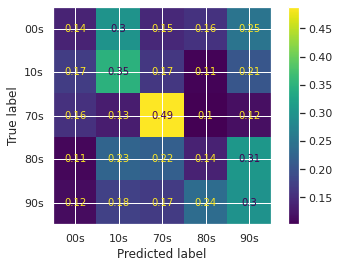

In [195]:
plot_confusion_matrix(clf, X_test, y_test,  normalize="true").figure_.savefig('results/actions_decade_confusion_matrix')

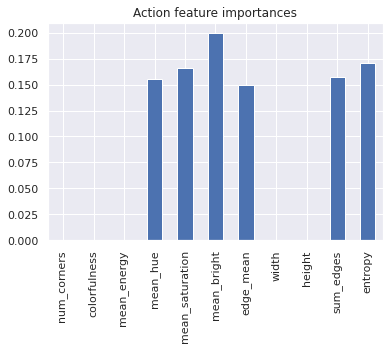

In [220]:
ser = pd.Series(data = clf.feature_importances_, index = X_train.columns)
ax = ser.plot(kind='bar', title = 'Action feature importances')
fig = ax.get_figure()
fig.savefig('results/action_decades_features')

In [179]:
%%time
FOLD_DIR = 'romance_posters/all'
romance_list = make_list(decades)
energy_list, hue_list, sat_list,val_list, edge_list,corners_list, colorfulness_list, width_list, height_list, sum_edge_list,entropy_list  = make_features(romance_list)
all_romance_feat=pd.DataFrame({'img':romance_list, 'num_corners': corners_list, 'colorfulness': colorfulness_list, 'mean_energy': energy_list, 'mean_hue':hue_list, 
                               'mean_saturation':sat_list,'mean_bright':val_list, 'edge_mean':edge_list, 'width':width_list, 'height':height_list, 'sum_edges':sum_edge_list,'entropy':entropy_list})
all_romance_feat['imdbId']=all_romance_feat.img.apply(lambda x: int(x.split('/')[-1].split('.')[0]))
all_romance_feat=all_romance_feat.merge(romance_sample, on='imdbId')

/opt/conda/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


CPU times: user 8min 14s, sys: 3.1 s, total: 8min 18s
Wall time: 7min 42s


In [205]:
X_train, X_test, y_train, y_test = train_test_split(all_romance_feat[['num_corners', 'colorfulness', 'mean_energy', 'mean_hue','mean_saturation','mean_bright', 'edge_mean', 'width', 'height', 'sum_edges','entropy']], all_romance_feat['decade'], test_size=0.33, random_state=42)

In [206]:
model = sklearn.svm.SVC(kernel='linear', C=10)

In [207]:
%%time
model.fit(X_train, y_train)

CPU times: user 22.3 ms, sys: 2 ms, total: 24.2 ms
Wall time: 22.4 ms


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [208]:
model.score(X_test,y_test)

0.23095823095823095

In [209]:
clf_2 = RandomForestClassifier(max_depth=10)
clf_2.fit(X_train, y_train)
clf_2.score(X_test, y_test)

0.2702702702702703

In [210]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cm

array([[17, 16, 20, 14, 15],
       [16, 31, 10, 11, 27],
       [19, 10, 34,  8,  9],
       [17,  9, 18, 10, 25],
       [13, 13, 22,  9, 14]])

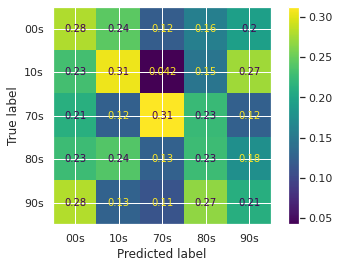

In [211]:
plot_confusion_matrix(clf_2, X_test, y_test,  normalize="true").figure_.savefig('results/romance_decade_confusion_matrix')

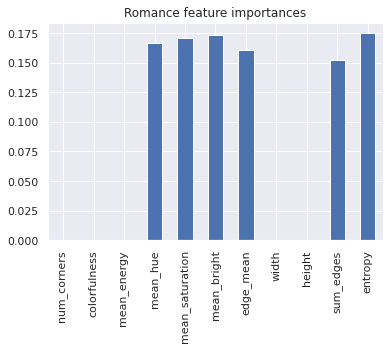

In [221]:
ser = pd.Series(data = clf_2.feature_importances_, index = X_train.columns)
ax = ser.plot(kind='bar', title = 'Romance feature importances')
fig = ax.get_figure()
fig.savefig('results/romance_decades_features')

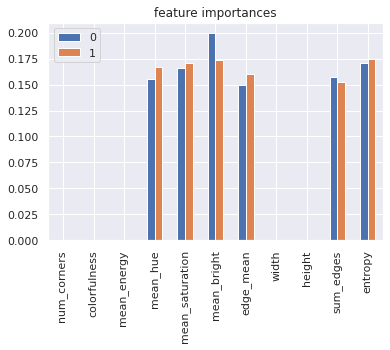

In [222]:
ax = pd.DataFrame([clf.feature_importances_, clf_2.feature_importances_], columns =X_train.columns ).T.plot(kind ='bar', title = 'feature importances')
fig = ax.get_figure()
fig.savefig('results/comparing_decades_features')